<a href="https://colab.research.google.com/github/nicholicaron/JustKnowStuff/blob/main/Optim_and_Init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

<ipython-input-30-40ae6389a848>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [31]:
# Path to folder where the datasets are downloaded
DATASET_PATH = "data"
# Path to folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models"

# Function for setting the seed
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [32]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it
for file_name in pretrained_files:
  file_path = os.path.join(CHECKPOINT_PATH, file_name)
  if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
      urllib.request.urlretrieve(file_url, file_path)
    except HTTPError as e:
      print("Something went wrong.")

In [33]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000,10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes
# Note that for actually training a model, we will use a different data loader
# with a lower batch size
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [34]:
# Calculation of the normalization parameters
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.2860405743122101
Std 0.3530242443084717


In [35]:
# We can verify the transformation by looking at the statistics of a single batch
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


In [36]:
class BaseNetwork(nn.Module):
  def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512,256,256,128]):
    """
    Inputs:
      act_fn - Object of the activation function that should be used as non-linearity in the network
      input_size - Size of the input images in pixels
      num_classes - Number of classes we want to predict
      hidden_sizes - A list of integers specifying the hidden layer sizes
    """
    super().__init__()

    # Create the network based on the specified hidden sizes
    layers = []
    layer_sizes = [input_size] + hidden_sizes
    for layer_index in range(1, len(layer_sizes)):
      layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index], act_fn)]
    layers += [nn.Linear(layer_sizes[-1], num_classes)]
    self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

    self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

  def forward(self, x):
    x = x.view(x.size(0), -1)
    for l in self.layers:
      x = l(x)
    return x

In [37]:
# Define identity activation so we can define a linear NN for comparison
class Identity(nn.Module):
  def forward(self, x):
    return x

act_fn_by_name = {
  "tanh": nn.Tanh,
  "relu": nn.ReLU,
  "identity": Identity
}

In [38]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
  columns = len(val_dict)
  fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
  fig_index = 0
  for key in sorted(val_dict.keys()):
    key_ax = ax[fig_index%columns]
    sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                 kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
    key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
    if xlabel is not None:
      key_ax.set_xlabel(xlabel)
    fig_index += 1
  fig.subplots_adjust(wspace=0.4)
  return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
  weights = {}
  for name, param in model.named_parameters():
    if name.endswith(".bias"):
      continue
    key_name = f"Layer {name.split('.')[1]}"
    weights[key_name] = param.detach().view(-1).cpu().numpy()

  ## Plotting
  fig = plot_dists(weights, color=color, xlabel="Weight vals")
  fig.suptitle("Weight distribution", fontsize=14, y=1.05)
  plt.show()
  plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
  """
  Inputs:
    net - Object of class BaseNetwork
    color - Color in which we want to visualize the histogram (for easier separation of activation functions)
  """
  model.eval()
  small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
  imgs, labels = next(iter(small_loader))
  imgs, labels = imgs.to(device), labels.to(device)

  # Pass one batch through the network, and calculate the gradients for the weights
  model.zero_grad()
  preds = model(imgs)
  loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of a module
  loss.backward()
  # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
  grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
  model.zero_grad()

  ## Plotting
  fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
  fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
  plt.show()
  plt.close()

  if print_variance:
    for key in sorted(grads.keys()):
      print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
  model.eval()
  small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
  imgs, labels = next(iter(small_loader))
  imgs, labels = imgs.to(device), labels.to(device)

  # Pass one batch through the network, and calculate the gradients for the weights
  feats = imgs.view(imgs.shape[0], -1)
  activations = {}
  with torch.no_grad():
    for layer_index, layer in enumerate(model.layers):
      feats = layer(feats)
      if isinstance(layer, nn.Linear):
        activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

  ## Plotting
  fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
  fig.suptitle("Activation distribution", fontsize=14, y=1.05)
  plt.show()
  plt.close()

  if print_variance:
    for key in sorted(activations.keys()):
      print(f"{key} - Variance: {np.var(activations[key])}")

##############################################################

In [39]:
model = BaseNetwork(act_fn=Identity()).to(device)

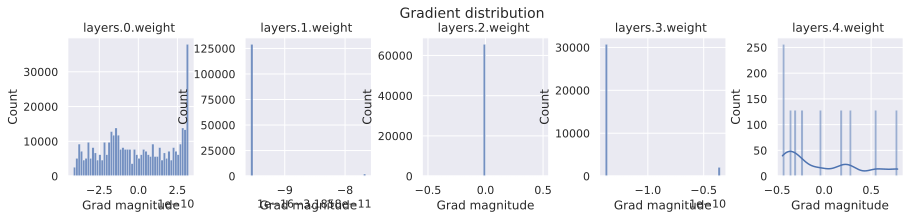

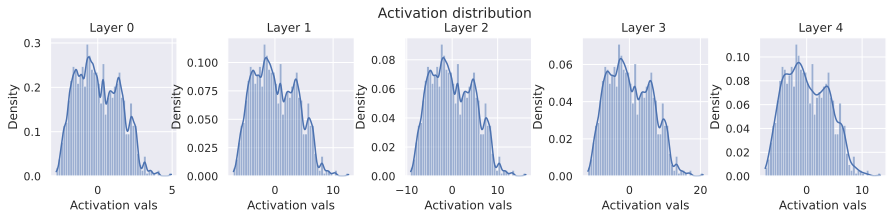

Layer 0 - Variance: 2.0582759380340576
Layer 1 - Variance: 13.489117622375488
Layer 2 - Variance: 22.100563049316406
Layer 3 - Variance: 36.209564208984375
Layer 4 - Variance: 14.831436157226562


In [40]:
def const_init(model, c=0.0):
  for name, param in model.named_parameters():
    param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

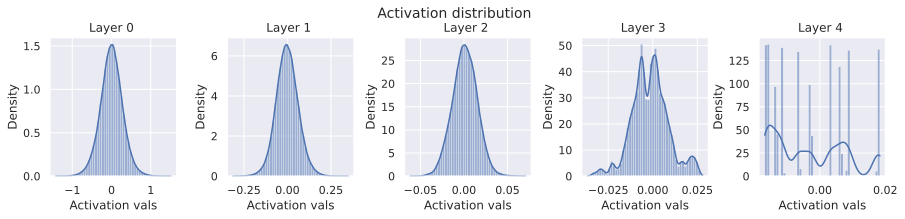

Layer 0 - Variance: 0.0797550156712532
Layer 1 - Variance: 0.004043167922645807
Layer 2 - Variance: 0.00020179587590973824
Layer 3 - Variance: 0.00010514973837416619
Layer 4 - Variance: 0.00012290490849409252


In [41]:
def var_init(model, std=0.01):
  for name, param in model.named_parameters():
    param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

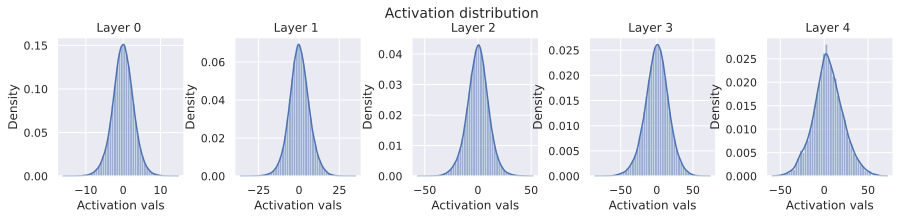

Layer 0 - Variance: 8.017800331115723
Layer 1 - Variance: 39.69389724731445
Layer 2 - Variance: 103.65348815917969
Layer 3 - Variance: 266.9234924316406
Layer 4 - Variance: 294.9678955078125


In [42]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

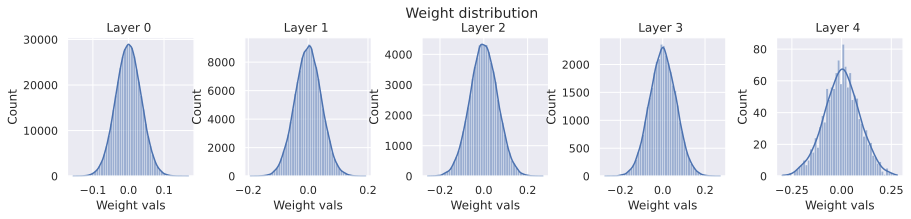

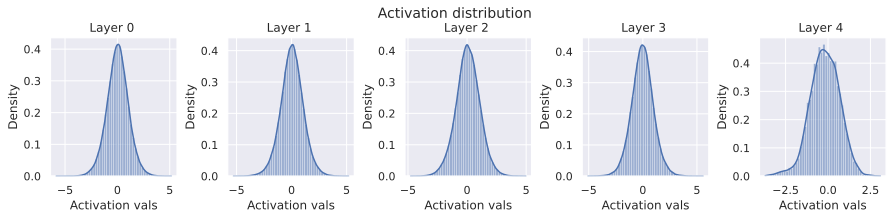

Layer 0 - Variance: 1.0563756227493286
Layer 1 - Variance: 1.0549169778823853
Layer 2 - Variance: 1.0106335878372192
Layer 3 - Variance: 1.0120643377304077
Layer 4 - Variance: 0.7572861909866333


In [43]:
def equal_var_init(model):
  for name, param in model.named_parameters():
    if name.endswith(".bias"):
      param.data.fill_(0)
    else:
      param.data.normal_(std=1.0/math.sqrt(param.shape[1]))

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

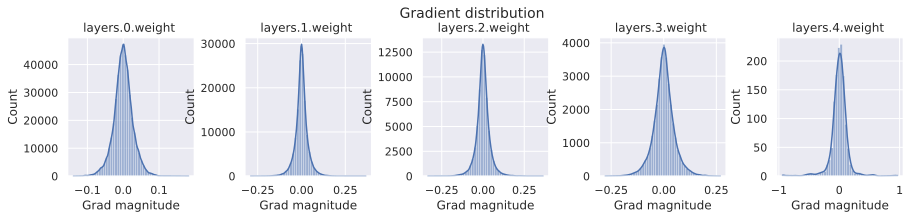

layers.0.weight - Variance: 0.0007123966352082789
layers.1.weight - Variance: 0.0013129538856446743
layers.2.weight - Variance: 0.0017101814737543464
layers.3.weight - Variance: 0.0024509974755346775
layers.4.weight - Variance: 0.021529555320739746


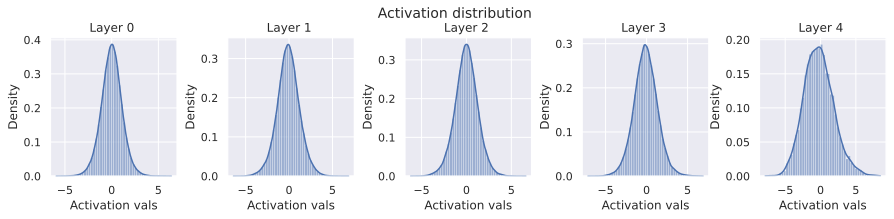

Layer 0 - Variance: 1.2349754571914673
Layer 1 - Variance: 1.6514812707901
Layer 2 - Variance: 1.5861326456069946
Layer 3 - Variance: 2.060638189315796
Layer 4 - Variance: 4.440850257873535


In [44]:
def xavier_init(model):
  for name, param in model.named_parameters():
    if name.endswith(".bias"):
      param.data.fill_(0)
    else:
      bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
      param.data.uniform_(-bound, bound)

xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

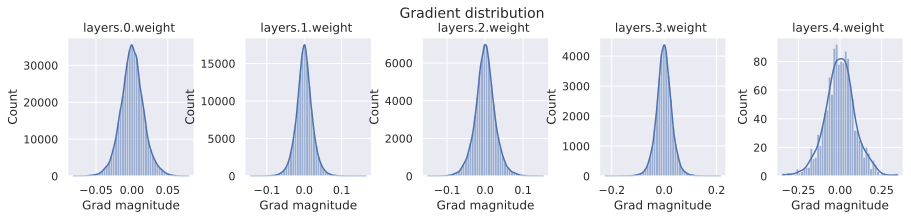

layers.0.weight - Variance: 0.0002611078380141407
layers.1.weight - Variance: 0.0004849364631809294
layers.2.weight - Variance: 0.0007152995676733553
layers.3.weight - Variance: 0.0009018866694532335
layers.4.weight - Variance: 0.008408118970692158


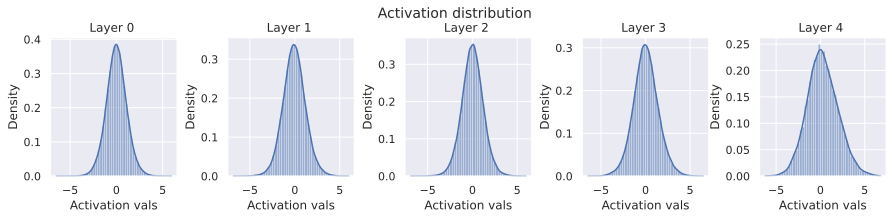

Layer 0 - Variance: 1.2106821537017822
Layer 1 - Variance: 1.5528786182403564
Layer 2 - Variance: 1.4328739643096924
Layer 3 - Variance: 1.9138188362121582
Layer 4 - Variance: 3.013033390045166


In [45]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

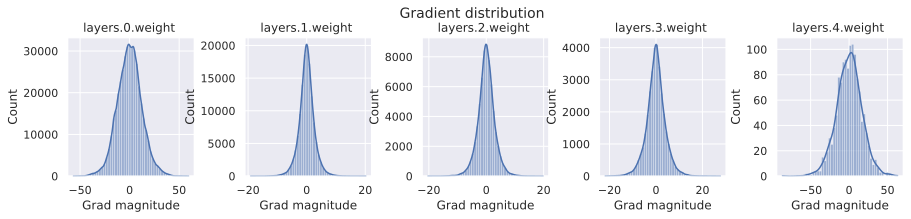

layers.0.weight - Variance: 153.7719268798828
layers.1.weight - Variance: 6.824926376342773
layers.2.weight - Variance: 8.55885124206543
layers.3.weight - Variance: 16.299087524414062
layers.4.weight - Variance: 272.99560546875


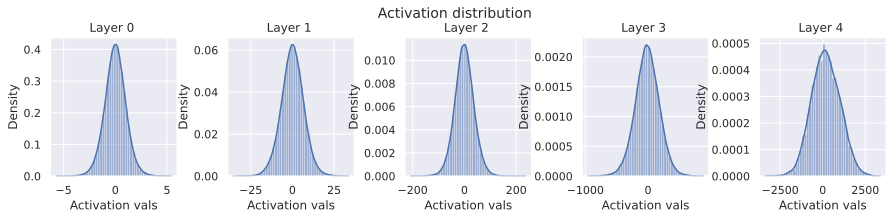

Layer 0 - Variance: 1.0521842241287231
Layer 1 - Variance: 45.812171936035156
Layer 2 - Variance: 1372.2813720703125
Layer 3 - Variance: 36879.78515625
Layer 4 - Variance: 688258.125


In [46]:
def kaiming_init(model):
  for name, param in model.named_parameters():
    if name.endswith(".bias"):
      param.data.fill_(0)
    elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
      param.data.normal_(0, 1/math.sqrt(param.shape[1]))
    else:
      param.data.normal_(0, math.sqrt(2/math.sqrt(param.shape[1])))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)